In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pulp

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [20]:
from pulp import LpProblem, LpMinimize, lpSum, LpVariable, value
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 读取.shp文件
shp_path = './LeedsCase/LeedsWards.shp'  # 请替换为你的.shp文件路径
gdf = gpd.read_file(shp_path)

# 生成每个小区域的质心
gdf['centroid'] = gdf['geometry'].centroid

# 添加一个名为 index 的新列，索引值从1开始
gdf['index'] = gdf.index + 1

# 创建一个字典，将 DataFrame 转换为字典
centroid_dict = gdf.set_index('index')['centroid'].to_dict()

# print(centroid_dict)


# 将质心坐标转换为数组
centroids = np.array([(point.x, point.y) for point in gdf['centroid']])

# 指定要选择的质心数量 n
n = 3

# 使用 KMeans 进行聚类
kmeans = KMeans(n_clusters=n, init=centroids[:n], n_init=1)  # 使用前 n 个质心作为初始值
gdf['cluster'] = kmeans.fit_predict(centroids)

# 确定聚类中心区域代码
# 定义函数，找到距离某个点最近的质心
def find_nearest_centroid(point, centroids):
    min_distance = float('inf')
    nearest_centroid = None
    for i, centroid in enumerate(centroids):
        distance = euclidean(point, centroid)
        if distance < min_distance:
            min_distance = distance
            nearest_centroid = i
    return nearest_centroid

# 初始化一个空列表，用于存储每个聚类中心对应的区域代码
selected_centroids_indexs = []

# 对每个聚类中心，找到最近的质心，并根据质心找到对应的区域代码
for centroid_index, centroid in enumerate(kmeans.cluster_centers_):
    nearest_centroid_index = find_nearest_centroid(centroid, centroids)
    nearest_ward_code = gdf.iloc[nearest_centroid_index]['index']
    selected_centroids_indexs.append(nearest_ward_code)



# 确定各区域到聚类中心距离
# 选择的聚类中心坐标
selected_centroids = kmeans.cluster_centers_

# 所有质心坐标
all_centroids = np.array([(point.x, point.y) for point in gdf['centroid']])



# 计算所有聚类中心到其他剩下所有质心的距离矩阵
distance_iv = cdist(selected_centroids, all_centroids, metric='euclidean')


ddf = pd.DataFrame(distance_iv)
ddf.index = selected_centroids_indexs

ddf.columns = gdf['index'].tolist()
# 转换为字典形式
stacked = ddf.stack()
ddf_dict = stacked.to_dict()
# 构建新的字典，交换键的顺序
new_d_vi = {(j, i): value for (i, j), value in ddf_dict.items()}



from pulp import *
# 定义函数，求解区域分配问题
def solve_region_assignment(tau, V, V_c, q_v, d_iv, s_v):
    p = n  # 中心的数量
    mu = sum(s_v.values()) / p  # 平均面积大小

    # 定义Lp问题
    prob = LpProblem("RegionAssignment", LpMinimize)

    # 定义变量 x_iv
    x = {(v, i): LpVariable(f'x_{v}_{i}', 0, 1, LpVariable.isBinary) for v in V for i in V_c}

    # 定义目标函数
    prob += lpSum(q_v[v] * d_iv[v, i] * x[v, i] for v in V for i in V_c)

    # 定义约束条件
    for v in V:
        prob += lpSum(x[v, i] for i in V_c) == 1

    for i in V_c:
        prob += (1 - tau) * mu <= lpSum(s_v[v] * x[v, i] for v in V) <= (1 + tau) * mu

    # 求解问题
    prob.solve()

    # 输出结果
    status = prob.status
    total_distance = pulp.value(prob.objective) 

    # 输出每个基本区域被分配给哪个中心
    assignments = {v: [i for i in V_c if value(x[v, i]) == 1] for v in V}

    return status, total_distance, assignments

# 重新计算平均面积大小
# 获取totalpop和area属性
q_v = dict(zip(gdf['index'], gdf['TotalPop']))
s_v = dict(zip(gdf['index'], gdf.area))  # 使用 .area 计算多边形面积

# 定义 V 和 V_c
V = gdf['index'].tolist()
V_c = selected_centroids_indexs
tau = 0.8
d_iv= new_d_vi

# 调用函数求解
status, total_distance, assignments = solve_region_assignment(tau, V, V_c, q_v, d_iv, s_v)

# 输出结果
print("Status:", status)
print("Total Distance:", total_distance)

# 输出每个基本区域被分配给哪个中心和区域面积
for i in V_c:
    total_area = sum(s_v[v] for v, assigned_centers in assignments.items() if i in assigned_centers)
    print(f"Total Area for Center {i}: {total_area}")

# 输出每个基本区域被分配给哪个中心和区域面积
for v, assigned_centers in assignments.items():
    print(f"Region {v} is assigned to Centers {assigned_centers}, Area: {s_v[v]}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/sv/w7v17_qd7hd1_rbk71lm_3lh0000gn/T/f1e3273a6cc64535851a48eefd4a3a01-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/sv/w7v17_qd7hd1_rbk71lm_3lh0000gn/T/f1e3273a6cc64535851a48eefd4a3a01-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 41 COLUMNS
At line 339 RHS
At line 376 BOUNDS
At line 476 ENDATA
Problem MODEL has 36 rows, 99 columns and 198 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 36 (0) rows, 99 (0) columns and 198 (0) elements
0  Obj 0 Primal inf 31.406376 (33)
33  Obj 3.432406e+09
Optimal - objective value 3.432406e+09
Optimal objective 3432406048 - 33 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU secon

In [21]:
# 创建一个字典，键是聚类中心，值是该聚类中心分配的区域列表
cluster_assignments = {center: [] for center in selected_centroids_indexs}

# 根据分配结果填充 cluster_assignments 字典
for ward, centers in assignments.items():
    for center in centers:
        cluster_assignments[center].append(ward)

# 打印划分结果
for center, wards in cluster_assignments.items():
    print(f"Center {center} has wards: {wards}")


Center 6 has wards: [1, 4, 6, 8, 12, 15, 18, 23, 24, 26, 27, 32]
Center 30 has wards: [2, 9, 11, 14, 16, 20, 28, 29, 30, 33]
Center 19 has wards: [3, 5, 7, 10, 13, 17, 19, 21, 22, 25, 31]


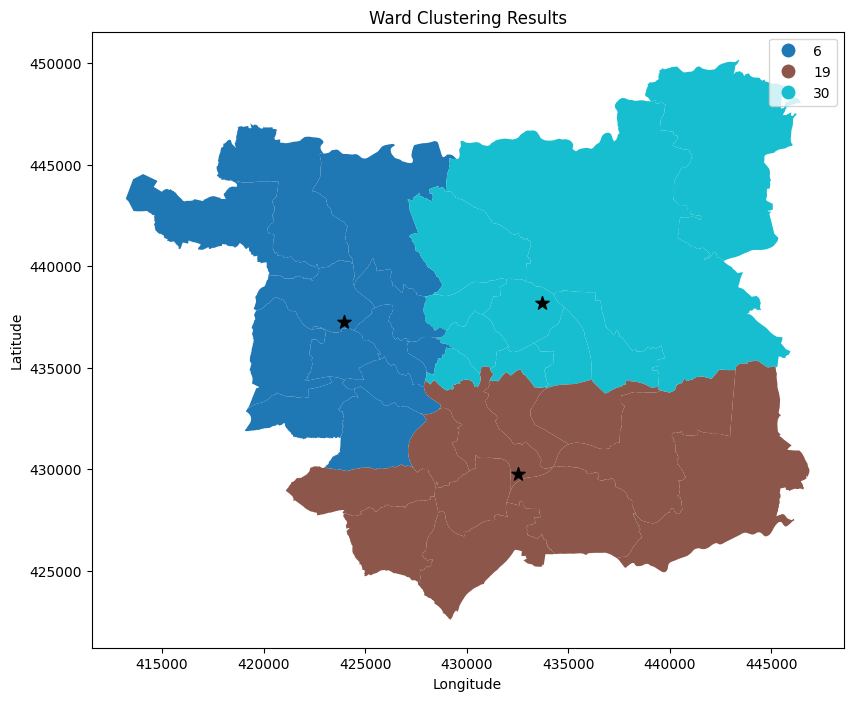

In [22]:
# 为地图中的划分结果添加新的列
def assign_cluster(x):
    clusters = [key for key, value in cluster_assignments.items() if x in value]
    if clusters:
        return clusters[0]
    else:
        return None

gdf['cluster'] = gdf['index'].apply(assign_cluster)

# 绘制地图
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='cluster', cmap='tab10', categorical=True, legend=True, ax=ax)

# 获取聚类中心点坐标
cluster_centroids_x = kmeans.cluster_centers_[:, 0]
cluster_centroids_y = kmeans.cluster_centers_[:, 1]

# 绘制聚类中心点
ax.scatter(cluster_centroids_x, cluster_centroids_y, c='black', marker='*', s=100, label='Cluster Centroids')

plt.title('Ward Clustering Results')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
